In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import wandb
import datetime

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
    
rng = np.random.default_rng(12345)

2024-04-29 14:40:08.516506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 14:40:08.516543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 14:40:08.518526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 14:40:08.527659: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 14:40:11.270305: W tensorflow/comp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
def check_wide(value):
    if value[1] < -2.5*value[0]+1.15:
        return False
    if value[1] > -2.5*value[0]+1.9:
        return False
    else:
        return True

def check_narrow(value):
    if value[0] < .15 or value[0] > .45:
        return False
    if value[1] < .5 or value[1] > 1.3:
        return False
    if value[1] < -2.5*value[0]+1.3:
        return False
    if value[1] > -2.5*value[0]+1.8:
        return False
    else:
        return True


def make_cosmogrid(value):
    wide = check_wide(value)
    narrow = check_narrow(value)
    if not wide:
        return False
    if not narrow:
        return np.random.choice([True, False], p=[.5, .5])
    else:
        return True

Shapes:
(100000, 10, 9, 2) (100000, 180) (100000, 186) (100000, 188)
N_train=36773, N_val=4540, N_test=3156



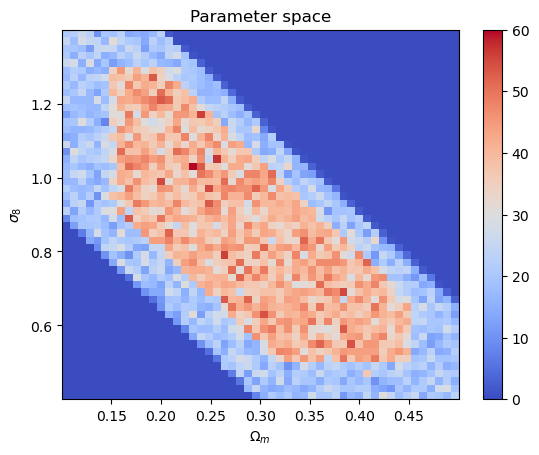

In [10]:
min_scale = 6 
nsims = 100000

savepath = '/data/taurus/users/dgebauer/temp/run1/'

theta = np.load(savepath + 'theta.npy')[:nsims] # [Om, s8, w, n_s, Ob, H0, ia , dnz1, dnz2, dnz3, dnz4, mpb1, mpb2, mpb3, mpb4, id]
theta_fixed = theta[:,2::1]
theta = theta[:,:2]


xip = np.load(savepath + 'xip.npy')[:nsims]
xim = np.load(savepath + 'xim.npy')[:nsims]

xi = np.concatenate((xip[:,:,min_scale:,None], xim[:,:,min_scale:,None]), axis=3)
xi_flat = xi.reshape(xi.shape[0], -1)
xi_fixed = np.concatenate((xi_flat, theta_fixed), axis=1)
xi_full = np.concatenate((xi_flat, theta, theta_fixed), axis=1)


base_path_fiducial = '/e/ocean1/users/dgebauer/sbi/measurements/fiducial/'
xip_fiducial = np.load(base_path_fiducial + 'xip.npy')[:,:,:,min_scale:].reshape(800,-1)
xim_fiducial = np.load(base_path_fiducial + 'xim.npy')[:,:,:,min_scale:].reshape(800,-1)
xi_fiducial = np.concatenate((xip_fiducial, xim_fiducial), axis=1)


cov = np.cov(xi_fiducial.T)
noise = rng.multivariate_normal(np.zeros(xi_fiducial.shape[1]), cov, xi_flat.shape[0])
xi_flat += noise


print("Shapes:")
print(xi.shape, xi_flat.shape, xi_fixed.shape, xi_full.shape)

x = xi_flat

cosmogrid_inds = np.apply_along_axis(make_cosmogrid, 1, theta)
x = x[cosmogrid_inds]        
theta = theta[cosmogrid_inds]

plt.hist2d(theta[:,0], theta[:,1], bins=50, density=False, cmap='coolwarm', norm='linear')
plt.title("Parameter space")
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\sigma_8$")
plt.colorbar()

y = theta[:,1] * np.sqrt(theta[:,0] / 0.3)
y_mean = y.mean(axis=0)
y_std = np.max(np.abs(y - y_mean))

val_inds = np.random.choice(np.arange(y.shape[0]), size=int(y.shape[0]*0.1), replace=False)
test_inds = np.random.choice(np.arange(y.shape[0]), size=int(y.shape[0]*0.1), replace=False)


y_val = (y[val_inds] - y_mean) / y_std
x_val = x[val_inds]
y_test = y[test_inds]
x_test = x[test_inds]
y_train = (np.delete(y, [val_inds, test_inds], axis=0) - y_mean) / y_std
x_train = np.delete(x, [val_inds, test_inds], axis=0)


x_test = x_test[np.apply_along_axis(check_narrow, 1, theta[test_inds])]
y_test = y_test[np.apply_along_axis(check_narrow, 1, theta[test_inds])]

s8_min = y_test.min()
s8_max = y_test.max()


print(f"N_train={x_train.shape[0]}, N_val={x_val.shape[0]}, N_test={x_test.shape[0]}\n")



In [11]:
def build_model():
    
    regularizer = tfk.regularizers.L1L2(l1=0.0, l2=0.0)
    regularizer_b = tfk.regularizers.L1L2(l1=0.0, l2=0.0)
    
    input = Input(shape=(x.shape[1],), name="input")
    y = input
    #y = BatchNormalization()(y)
    #y = Dense(256, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    #y = Dense(256, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    y = Dense(128, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    y = Dense(128, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    y = Dense(128, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    y = Dense(64, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    #y = Dense(32, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    y = Dense(16, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    #y = Dense(8, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    #y = Dense(4, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    #y = Dense(2, activation='LeakyReLU', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    y = Dense(1, activation='tanh', kernel_regularizer=regularizer, bias_regularizer=regularizer_b)(y)
    
    return Model(inputs=input, outputs=y)

model = build_model()

loss = tf.keras.losses.MeanSquaredError()
model.summary()

checkpoint = ModelCheckpoint(filepath='model.keras', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=2)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [EarlyStopping(patience=30, monitor='val_loss', restore_best_weights=True, verbose=2),
            checkpoint,
            tensorboard,
            ReduceLROnPlateau(patience=20, monitor='val_loss', verbose=2, factor=0.1, restore_best_weights=True),
            ReduceLROnPlateau(patience=10, monitor='loss', verbose=2, factor=0.1, restore_best_weights=True),
            ]

model.load_weights('model_run1.h5')

Model: "model_2"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 180)]             0         
                                                                 
 dense_12 (Dense)            (None, 128)               23168     
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 128)               16512     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 16)                1040      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
          

In [8]:
#wandb.init(project='reverse_emulator', sync_tensorboard=True)


for lr in np.logspace(-5, -3, 6)[:-1]:
    optimizer_init = tf.keras.optimizers.SGD(learning_rate=lr)
    #model.compile(optimizer=optimizer_init, loss=loss)
    #model.fit(x_train, y_train, epochs=1, batch_size=128, callbacks=checkpoint, validation_data=(x_val, y_val))


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7, beta_1=0.9, beta_2=0.999, epsilon=1e-09, jit_compile=True, use_ema=False, ema_overwrite_frequency=150)
model.compile(optimizer=optimizer, loss=loss)
model.fit(x_train, y_train, epochs=10000, batch_size=64, callbacks=callbacks, validation_data=(x_val, y_val))


model.load_weights('model.keras')
#wandb.run.summary["state"] = "completed"
#wandb.finish()  


Epoch 1/10000


2024-04-29 14:40:47.262186: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f75d14e3580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 14:40:47.262213: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-29 14:40:47.269255: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 14:40:47.306221: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1714394447.482173  122115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 31/577 [>.............................] - ETA: 3s - loss: 0.0072

KeyboardInterrupt: 

99/99 [==============================] - 0s 2ms/step


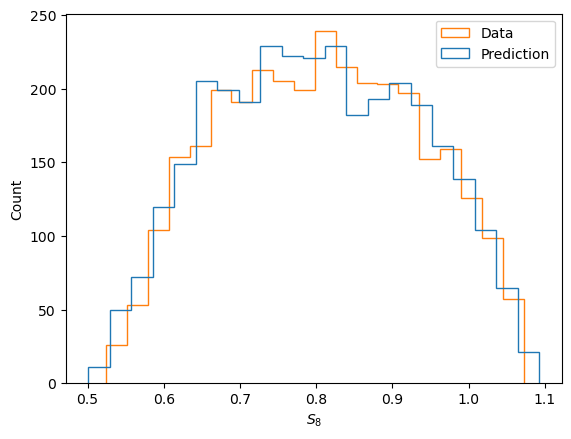

In [12]:
pred = model.predict(x_test)[:,0] * y_std + y_mean

#plt.scatter(y_test[:,0], y_test[:,1], c='C2', alpha=.2, s=1, label='Data')
#plt.scatter(pred[:,0], pred[:,1], c='C1', alpha=.7, s=1, label='Prediction')

_ = plt.hist(y_test, bins='auto', histtype='step', color='C1', label='Data')
_ = plt.hist(pred[:], bins='auto', histtype='step', color='C0', alpha=1, label='Prediction')

plt.xlabel(r'$S_8$')
plt.ylabel('Count')
plt.legend()

Correlation Coefficients:   0.968
Mean Absolute Error:        0.027
Larger than 0.05:           0.124
Standard Deviation:         0.033


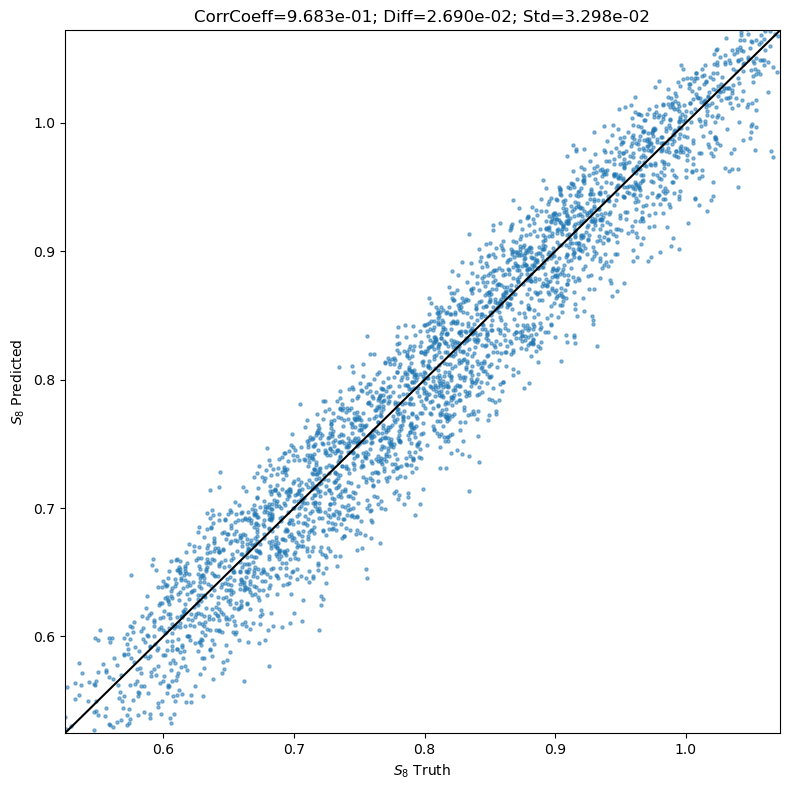

In [13]:
"""
corr_omm = np.corrcoef(y_test[:,0], pred[:,0])[1,0]
corr_s8 = np.corrcoef(y_test[:,1], pred[:,1])[1,0]
std_omm = np.std(y_test[:,0] - pred[:,0])
std_s8 = np.std(y_test[:,1] - pred[:,1])
omm_10p = np.where(np.abs(y_test[:,0] - pred[:,0]) > 0.05)[0].shape[0] / y_test.shape[0]
s8_10p = np.where(np.abs(y_test[:,1] - pred[:,1]) > 0.05)[0].shape[0] / y_test.shape[0]
omm_mae = np.mean(np.abs(y_test[:,0] - pred[:,0]))
s8_mae = np.mean(np.abs(y_test[:,1] - pred[:,1]))

print(f"Correlation Coefficients:   Om={corr_omm:.3f}; s8={corr_s8:.3f}")
print(f"Mean Absolute Error:        Om={omm_mae:.3f}; s8={s8_mae:.3f}")
print(f"Larger than 0.05:           Om={omm_10p:.3f}; s8={s8_10p:.3f}")
print(f"Standard Deviation:         Om={std_omm:.3f}; s8={std_s8:.3f}")
print()



fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(y_test[:,0], pred[:,0], c='C0')
ax[0].plot([0., 0.6], [0,0.6], c='k')
ax[0].set_title(f"CorrCoeff={corr_omm:.3e}; Diff={omm_mae:.3e}; Std={std_omm:.3e}", fontsize=12)
ax[0].set_xlim(0.05, 0.55)
ax[0].set_ylim(0.05, 0.55)
ax[0].set_xlabel(r'$\Omega_m$ Truth')
ax[0].set_ylabel(r'$\Omega_m$ Predicted')


ax[1].scatter(y_test[:,1], pred[:,1], c='C0')
ax[1].plot([0.3, 1.5], [0.3, 1.5], c='k')
ax[1].set_title(f"CorrCoeff={corr_s8:.3e}; Diff={s8_mae:.3e}; Std={std_s8:.3e}", fontsize=12)
ax[1].set_xlim(0.35, 1.45)
ax[1].set_ylim(0.35, 1.45)
ax[1].set_xlabel(r'$\sigma_8$ Truth')
ax[1].set_ylabel(r'$\sigma_8$ Predicted')
fig.tight_layout()
#fig.savefig('i3pcf3_100pca_4dense.png')
"""


corr = np.corrcoef(y_test, pred)[1,0]
std = np.std(y_test - pred)
mae = np.mean(np.abs(y_test - pred))
outlier = np.where(np.abs(y_test - pred) > 0.05)[0].shape[0] / y_test.shape[0]

print(f"Correlation Coefficients:   {corr:.3f}")
print(f"Mean Absolute Error:        {mae:.3f}")
print(f"Larger than 0.05:           {outlier:.3f}")
print(f"Standard Deviation:         {std:.3f}")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(y_test, pred, c='C0', alpha=0.5, s=5)
ax.plot([s8_min, s8_max], [s8_min, s8_max], c='k')
ax.set_title(f"CorrCoeff={corr:.3e}; Diff={mae:.3e}; Std={std:.3e}", fontsize=12)
ax.set_xlim(s8_min, s8_max)
ax.set_ylim(s8_min, s8_max)
ax.set_xlabel(r'$S_8$ Truth')
ax.set_ylabel(r'$S_8$ Predicted')
fig.tight_layout()


/tmp/ipykernel_102504/2331157057.py:8: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


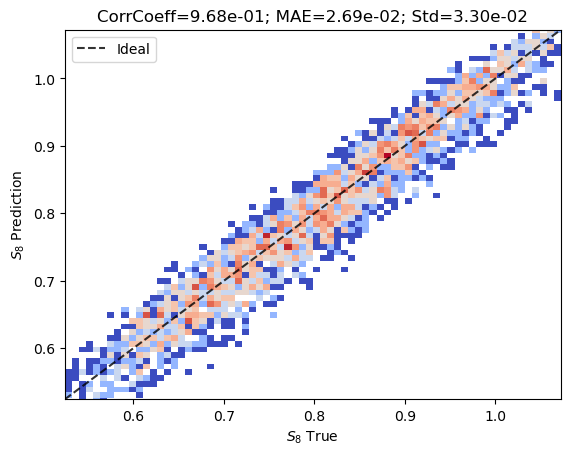

In [18]:
_ = plt.hist2d(y_test, pred, bins=70, cmap='coolwarm', label='Data', norm='log')
plt.title(f"CorrCoeff={corr:.2e}; MAE={mae:.2e}; Std={std:.2e}", fontsize=12)
plt.xlabel(r'$S_8$ True')
plt.ylabel(r'$S_8$ Prediction')
plt.plot([s8_min, s8_max], [s8_min, s8_max], c='k', ls='--', lw=1.5, alpha=.8 ,label='Ideal')
plt.xlim(s8_min, s8_max)
plt.ylim(s8_min, s8_max)
plt.legend()
#plt.tight_layout()

In [20]:
#model.save('model_run1.h5')
#model.load_weights('model_run1.h5')